# Feature Extraction of Image

In [1]:
import torch
import torch.nn as nn
from torchvision.models import resnet18
from collections import namedtuple
import matplotlib.pyplot as plt

from PIL import Image, ImageOps, ImageEnhance, ImageFilter
from torchvision import transforms, datasets
import numpy as np
import torchvision.transforms.functional as F



preprocess = transforms.Compose([
    transforms.Resize(256), #256
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [2]:
import os
import re
file_list = os.listdir("sample_images/")

In [3]:
file_list #show image filenames

['apple_2.png',
 'apple_1.png',
 'apple_8.jpg',
 'apple_4.png',
 'apple_7.jpg',
 'apple_6.png',
 'apple_3.png',
 'apple_5.png']

In [4]:
#create DL architecture from resnet18
class Resnet18(torch.nn.Module):
    def __init__(self):
        super(Resnet18, self).__init__()
        features = list( resnet18(pretrained = True).children() )[:8]
        self.features = nn.ModuleList(features).eval() 
        
    def forward(self, x):
        with torch.no_grad():
            layer_outputs = []
            for layer,model in enumerate(self.features):
                x = model(x)
            avg = nn.AdaptiveAvgPool2d( (1, 1) ) #average the last layer
            feature = avg(x).squeeze()

            
            return feature.flatten() # return the image feature

In [5]:
test_m = Resnet18()

embedding = []
for file_name in file_list:
    try:
        rgba_image = Image.open(f'sample_images/{file_name}')
        input_image = rgba_image.convert('RGB')
        input_tensor = preprocess(input_image)
        input_batch = input_tensor.unsqueeze(0) # create a mini-batch as expected by the model by insering a dimension to the model

        embb = test_m.forward( input_batch )
        embb = np.array(embb)
    except:
        embb = np.zeros(512)
        print("File Corrupted:",file_name)

    embedding.append(embb)

embedding = np.array(embedding)   

/home/subrat/anaconda3/lib/python3.8/site-packages/PIL/Image.py:962: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


In [6]:
embedding.shape

(8, 512)

In [7]:
from sklearn.metrics.pairwise import cosine_similarity
# cosine_similarity(embedding[0].reshape(1, -1), embedding[0].reshape(1, -1))
corr = cosine_similarity(embedding)

In [9]:
corr

array([[1.        , 0.8488487 , 0.74564266, 0.7401081 , 0.8466448 ,
        0.82969064, 0.82175076, 0.7646676 ],
       [0.8488487 , 1.        , 0.8021113 , 0.79801685, 0.87041306,
        0.85927486, 0.90761775, 0.8282877 ],
       [0.74564266, 0.8021113 , 1.0000001 , 0.7238499 , 0.893631  ,
        0.7755171 , 0.8023988 , 0.7217093 ],
       [0.7401081 , 0.79801685, 0.7238499 , 1.        , 0.7439215 ,
        0.8172976 , 0.82594687, 0.7902893 ],
       [0.8466448 , 0.87041306, 0.893631  , 0.7439215 , 1.        ,
        0.8108857 , 0.857881  , 0.7336067 ],
       [0.82969064, 0.85927486, 0.7755171 , 0.8172976 , 0.8108857 ,
        0.9999999 , 0.85845864, 0.79729927],
       [0.82175076, 0.90761775, 0.8023988 , 0.82594687, 0.857881  ,
        0.85845864, 1.0000002 , 0.8581268 ],
       [0.7646676 , 0.8282877 , 0.7217093 , 0.7902893 , 0.7336067 ,
        0.79729927, 0.8581268 , 1.0000002 ]], dtype=float32)

In [10]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [11]:
# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

Text(159.0, 0.5, '[ImageName].jpg')

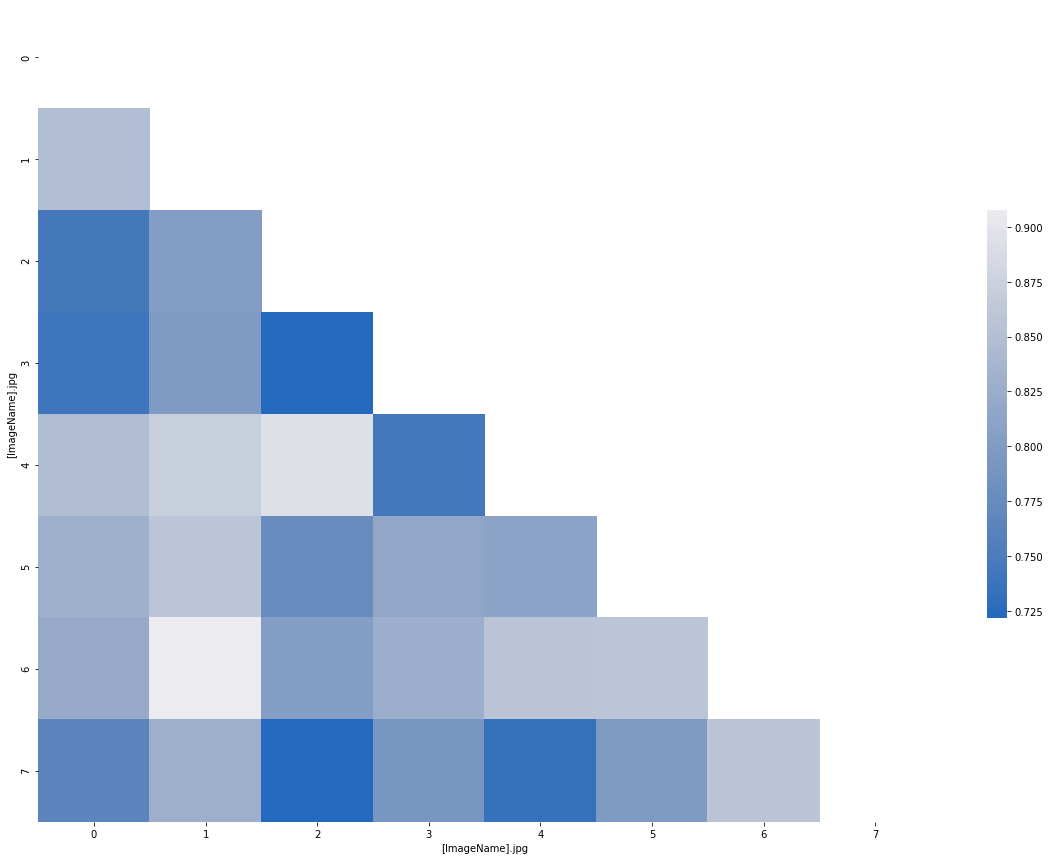

In [12]:
# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(20, 15))


# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, center=0.93, cbar_kws={"shrink": 0.5}, cmap="vlag", annot=False)
plt.xlabel('[ImageName].jpg')
plt.ylabel('[ImageName].jpg')
# f.savefig('heat_map.pdf', bbox_inches='tight')

In [13]:
embb_r = np.round(embedding, decimals=2)
np.savetxt("embedding.csv", embb_r, delimiter=",")